<span id="#toc" style='font-size: 20pt; font-weight: bold'>TABLE OF CONTENTS</span>

<span style='font-size: 15pt; text-decoration: none; display: block;'>
  <a href="#slidebar" style="font-size: 15pt; text-decoration: none;">
    Slide Bar 
  </a>
</span>

<span id='import-lib' style='color:#008000; font-size:20pt; font-weight:bold'>Import Libraries</span>

In [1]:
import pyvista as pv
import numpy as np
from collections import deque
import open3d as o3d
import math
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<span id='load-data' style='color:#008000; font-size:20pt; font-weight:bold'>Load Data </span>

In [ ]:
# brick_part01 = pv.read('D:\\Learn_and_Study\\USTH\\Bachelor\\3D_Project\\CG_dataset\\brick_part01.obj')

In [2]:
pcd = o3d.io.read_point_cloud("D:\\Learn_and_Study\\USTH\\Bachelor\\3D_Project\\CG_dataset\\brick_part01_smoothen.pcd")
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))

# RECONSTRUCT SURFACE MESH BY POISSON AND CONVERT INTO PYVISTA
mesh_o3d, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=8)
mesh_o3d.compute_vertex_normals()

vertices = np.asarray(mesh_o3d.vertices)
triangles = np.asarray(mesh_o3d.triangles)
faces = np.hstack([np.full((len(triangles), 1), 3), triangles]).flatten()  # Add face header

mesh_pv = pv.PolyData(vertices, faces)

In [3]:
mesh = mesh_pv
mesh

PolyData,Information
N Cells,278344
N Points,139174
N Strips,0
X Bounds,"-3.334e+00, 2.966e+00"
Y Bounds,"-1.180e+00, 1.877e+00"
Z Bounds,"-3.381e+00, 3.769e+00"
N Arrays,0


<span style='color:#008000; font-size:20pt; font-weight:bold'>Curvature</span>

In [8]:
curvature = mesh.curvature(curv_type='mean')
# min_curv = np.fabs(mesh.curvature(curv_type='minimum'))
# max_curv = np.fabs(mesh.curvature(curv_type='maximum'))
# curv = np.maximum(min_curv, max_curv)
clim = [np.percentile(curvature, 3), np.percentile(curvature, 90)]

Total points: 139174
Min: -184.7804, Max: 1043.7523, Mean: 0.5094


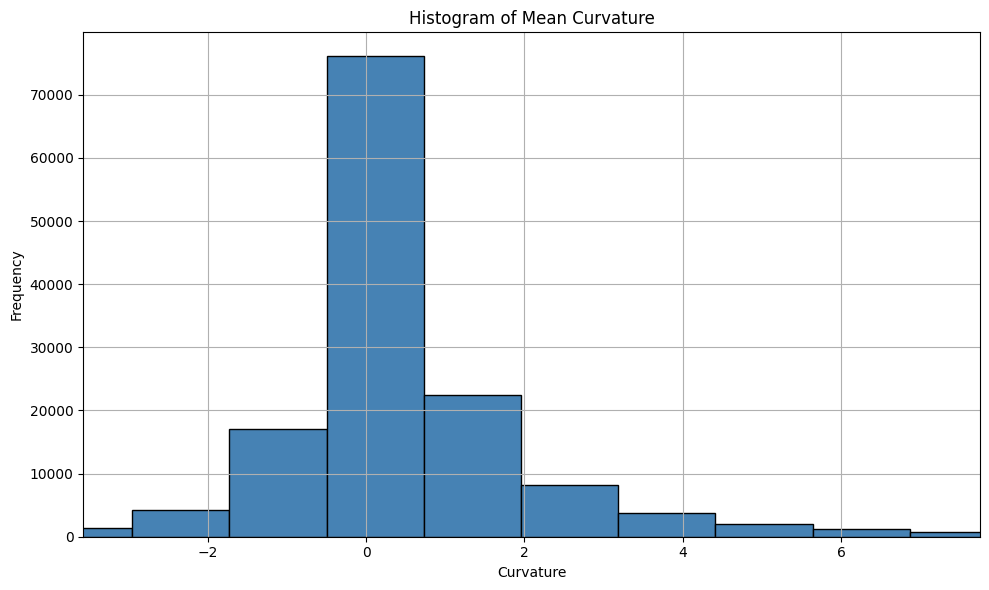

In [5]:
import matplotlib.pyplot as plt

print(f"Total points: {mesh.n_points}")
print(f"Min: {np.min(curv):.4f}, Max: {np.max(curv):.4f}, Mean: {np.mean(curv):.4f}")

plt.figure(figsize=(10, 6))
plt.hist(curv, bins=1000, color='steelblue', edgecolor='black')
plt.title(f"Histogram of Mean Curvature")
plt.xlabel("Curvature"), plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.xlim(np.percentile(curv, 1), np.percentile(curv, 99))
plt.show()

<span style='color:#008000; font-size:20pt; font-weight:bold'>Neighbors Propagation</span>

<span style='color:#007ACC; font-size:15pt; font-weight:bold'>Mesh Simplification and Smoothing</span>

In [ ]:
# import fast_simplification
# mesh = fast_simplification.simplify_mesh(brick_part01, target_reduction=0.5)
# mesh = mesh.smooth(n_iter=500)  

<span style='color:#007ACC; font-size:15pt; font-weight:bold'>Functions</span>

In [11]:
def significant_curvature_difference(curvature, point, n_rings, threshold=1.0):
    neighbors_flat = list()
    neighbors = mesh.point_neighbors_levels(point, n_rings)

    for i, neighbor in enumerate(neighbors):
        neighbors_flat.extend(neighbor)

    if len(neighbors_flat) == 0:
        raise Exception("The point has no neighbor")

    avg_curvature = np.mean(curvature[list(neighbors_flat)])

    # std_curvature = np.std(neighbor_curvatures)
    # if abs(std_curvature - avg_curvature) > threshold * std_curvature:

    return abs(curvature[point] - avg_curvature) >= threshold
    
def local_max_curvature_point(curvature, founded_points: list|set):
    if len(founded_points) == len(curvature): raise Exception("Has visited all points")
    curvature_copy = copy.deepcopy(curvature)
    for point in founded_points:
        curvature_copy[point] = -(math.inf)
    return np.argmax(curvature_copy)

def propagate_with_curvature_threshold(curvature, propagated, start_point, threshold):
    # threshold = np.percentile(mean_curvature, 90)
    if curvature[start_point] < threshold:
        raise Exception("Starting point does not satisfy curvature threshold")

    visited = set()
    queue = deque([start_point])  
    result = set()

    result.add(start_point)

    while queue:

        point = queue.popleft()
        if point in visited:
            continue
        visited.add(point)

        for neighbor in mesh.point_neighbors(point):
            if neighbor not in visited and neighbor not in propagated:
                if curvature[neighbor] >= threshold:
                    result.add(neighbor)
                    queue.append(neighbor)
    if result: 
        propagated.update(result)
        return result
    else: raise Exception("Propagation result is empty")

def local_max_curvature_point_on_edge(curvature, visited, max_points_on_edge:list):
    while True:
        max_point = local_max_curvature_point(curvature, visited)
        if not significant_curvature_difference(curvature, max_point, n_rings=2, threshold=1.0):
            max_points_on_edge.append(max_point)
            visited.add(max_point)
            break
        visited.add(max_point)

    print(f"Number of visited: {len(visited)}")
    print(f"Number of max_points_on_edge: {len(max_points_on_edge)}")

def scene_setting(plotter, edges: list|set=None, title: str=None, position: tuple=None):

    def list_has_sublist_or_subset(lst):
        return any(isinstance(e, list|set) for e in lst)
    
    if position: plotter.subplot(*position)
    if title: plotter.add_text(title)
    if edges:
        if list_has_sublist_or_subset(edges):
            for i, edge in enumerate(edges):
                plotter.add_mesh(mesh.points[(list(edge))], color=colors[i], point_size=10, render_points_as_spheres=True)    
        else: 
            plotter.add_mesh(mesh.points[(list(edges))], color=colors[0], point_size=10, render_points_as_spheres=True)    
             
    plotter.add_mesh(mesh.points[max_points_on_edge], color='white', point_size=12, render_points_as_spheres=True)
    plotter.add_mesh(mesh, show_edges=True, scalars=curvature, clim=clim)

# def screenshot():
    # import os
    # plotter = pv.Plotter(off_screen=True)
    # scene_setting(plotter)

    # for name, view in camera_views.items():
    #     plotter.camera_position = view
    #     plotter.screenshot(os.path.join(save_dir, f"result_{name}.png"))
    # plotter.close()

def erose_condition(edge, point, condition: str, n_rings=1):
    neighbors = mesh.point_neighbors_levels(point, n_levels=n_rings)
    neighbors = set().union(*neighbors)

    def most(iterable):
        lst = list(iterable)
        return sum(bool(x) for x in lst) > len(lst) // 2

    if condition == "most":
        return most(neighbor in edge for neighbor in neighbors)

    if condition == "all":
        return all(neighbor in edge for neighbor in neighbors)

def erosion(edge, condition: str = "most", n_rings=1, iterations=1, single_line: bool=False):
    '''
    Input: List of points as edge
    Output: List of points after removal
    Algorithm: If all or most n_ring_neighbors of a point belong to edge -> Keep the point
               Otherwise, remove the point
    '''
    edge_copy = set(copy.deepcopy(edge))

    while iterations != 0:
        removal_points = set()

        for point in edge_copy:
            if not erose_condition(edge_copy, point, condition=condition, n_rings=n_rings):
                removal_points.add(point)
        
        edge_copy.difference_update(removal_points)
        iterations -= 1
    return edge_copy

<span style='color:#008000; font-size:20pt; font-weight:bold'>Rendering</span>

In [12]:
all_point_ids = list(range(mesh.n_points))
visited = set()
max_points_on_edge = list()
edge_vertices = list()

iterations = 4
thresholds = [2, 1.8, 1.5, 1]

colors = ['red', 'dodgerblue', 'green', 'yellow', 'magenta', 'orangered', 'chocolate']

# camera_views = {
#         "xy_top": "xy",
#         "xz_front": "xz",
#         "yz_side": "yz",
#         "iso_view": "iso",
#         "corner_1": [-1, -1, 1],
#         "corner_2": [1, 1, 1],
#         "corner_3": [-1, 1, 1],
#         "corner_4": [1, -1, 1],
#         "bottom_up": [0, 0, -1],
#     }

# save_dir = "screenshots"

for i in range(iterations):
    local_max_curvature_point_on_edge(curvature, visited, max_points_on_edge)
    edge = propagate_with_curvature_threshold(curvature, visited, max_points_on_edge[i], thresholds[i])
    if edge:
        edge_vertices.append(edge)
        print(f"** Iteration {i}: {len(edge)} points | Max Curvature: {curvature[max_points_on_edge[i]]:.4f} | Average Curvature: {np.mean(curvature[list(edge)]):.4f}")
    else:
        print(f"** Iteration {i}: No points propagated — threshold = {thresholds[i]:.2f}")

erosed_edges_all = list()
erosed_edges_most = list()


for edge in edge_vertices:
    erosed = erosion(edge, condition="all")
    erosed_edges_all.append(erosed)

for edge in edge_vertices:
    erosed = erosion(edge, condition="most")
    erosed_edges_most.append(erosed)

plotter = pv.Plotter(shape=(2, 2))

scene_setting(plotter, title="Mesh", position=(0, 0))
scene_setting(plotter, erosed_edges_all, title="Edges", position=(0, 1))
scene_setting(plotter, erosed_edges_all, title="Erode: 'all' 1 time", position=(1, 0))
scene_setting(plotter, erosed_edges_most, title="Erode: 'most' 1 time", position=(1, 1))

plotter.show(cpos='xy')

Number of visited: 523
Number of max_points_on_edge: 1
** Iteration 0: 1047 points | Max Curvature: 10.8613 | Average Curvature: 4.4249
Number of visited: 1786
Number of max_points_on_edge: 2
** Iteration 1: 3685 points | Max Curvature: 9.6082 | Average Curvature: 4.0768
Number of visited: 5490
Number of max_points_on_edge: 3
** Iteration 2: 1482 points | Max Curvature: 9.4557 | Average Curvature: 3.0880
Number of visited: 7008
Number of max_points_on_edge: 4
** Iteration 3: 11861 points | Max Curvature: 9.1650 | Average Curvature: 2.8787


Widget(value='<iframe src="http://localhost:57575/index.html?ui=P_0x27a73143af0_2&reconnect=auto" class="pyvis…